# <font color = 'indianred'>**HW4A - Prachi Dalal** </font>


# <font color = 'indianred'>**Load Dataset** </font>

In [1]:
#import necessary libraries
import torch
import torch.nn as nn
from torchtext.vocab import vocab

import random
import numpy as np

import joblib
from collections import Counter

from functools import partial

from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
get_ipython()

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install -U spacy -qq

In [4]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext -qq
    !pip install torchinfo -qq

import os
os.chdir("/content/drive/MyDrive/BUAN 6342")


Mounted at /content/drive


In [5]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/BUAN 6342


In [6]:
file_path = "df_multilabel_hw_cleaned.joblib"
df = joblib.load(file_path)
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


# <font color = 'indianred'>**Prepare Dataset** </font>

- *Convert Tag_Number to Integers*

In [7]:
import ast
df['Tag_Number'] = df['Tag_Number'].apply(ast.literal_eval)

- *One Hot Encoding for Dependent Variable*

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

mlb = MultiLabelBinarizer()
labels_encoded  = mlb.fit_transform(df['Tag_Number'])
labels_df = pd.DataFrame(labels_encoded, columns=mlb.classes_)

#merge
df = pd.concat([df, labels_df], axis=1)
df

,cleaned_text,Tags,Tag_Number,0,1,2,3,4,5,6,7,8,9
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
1,run javascript code server java code want run ...,java javascript,"[1, 3]",0,1,0,1,0,0,0,0,0,0
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
3,run python script php server run nginx web ser...,php python,"[2, 7]",0,0,1,0,0,0,0,1,0,0
4,advice write function m try write function res...,javascript jquery,"[3, 5]",0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47423,listen phone state application nee liste phone...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47424,android ui thread thread task want access main...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]",0,0,0,1,0,0,0,0,0,1


- *Split Dataset:Use 60% for train, 20 % for the test, and the remaining 20% for the validation dataset.*

In [11]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df.iloc[:, 3:]

# Split the data into train (60%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Reset the indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Split rest of 40% by half: validation (20%) and test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reset the indices
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Convert to list of strings
X_train_list = X_train.tolist()
X_valid_list = X_valid.tolist()
X_test_list = X_test.tolist()

y_train_np = y_train.to_numpy()
y_valid_np = y_valid.to_numpy()
y_test_np = y_test.to_numpy()

# Check
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Train set indices:", X_train.index)
print("Validation set indices:", X_valid.index)
print("Test set indices:", X_test.index)
print(type(X_train_list))
print(type(y_train_np))

Train set shape: (28456,) (28456, 10)
Validation set shape: (9485,) (9485, 10)
Test set shape: (9486,) (9486, 10)
Train set indices: RangeIndex(start=0, stop=28456, step=1)
Validation set indices: RangeIndex(start=0, stop=9485, step=1)
Test set indices: RangeIndex(start=0, stop=9486, step=1)
<class 'list'>
<class 'numpy.ndarray'>


# <font color = 'indianred'>**Part A (Neural Network in PyTorch using Dense Embeddings)** </font>

# <font color = 'indianred'>**(1) Model Training: Training and evaluation on Validation set** </font>

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [13]:
# Create custom datasets for train, validation, and test sets
trainset = CustomDataset(X_train_list, y_train_np)
validset = CustomDataset(X_valid_list, y_valid_np)
testset = CustomDataset(X_test_list, y_test_np)

In [14]:
pprint(trainset[4])
print()
text_of_fifth_sample = trainset[4][1]

pprint(text_of_fifth_sample, width=80)

type(text_of_fifth_sample)

(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1]),
 'pass value server control jquery update code code dynamic label contrtol '
 'following jquery code work pass value test want pass value label control '
 'lblnames label control collect upload file name way jquery $ '
 'document).ready(function      $ btnupload").click(function          $ notes '
 'top.document).val(\'t        aspx code < asp label id="lblnames '
 'runat="server visible="true > < /asp label >   code      protect sub '
 'btnupload_click(byval sender object byval e system eventargs     handles '
 'btnupload click      dim fileext string      fileext = system io.path '
 'getextension(fileupload1.filename       fileext < > .exe          dim '
 'filename new list(of string           try              dim hfc '
 'httpfilecollection = request file              lblfile text = '
 'string              lblname text = string               integer = 0 hfc '
 'count 1                  dim hpf httppostedfile = hfc(i                  hpf '
 'con

str

In [15]:
label_of_fifth_sample = trainset[4][0]
label_of_fifth_sample

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [16]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (label, text) in dataset:
        counter.update(text.split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [17]:
slack_vocab = get_vocab(trainset, min_freq=2)

In [18]:
#check
print(len(slack_vocab))
print(slack_vocab.get_itos())
print(slack_vocab['rearrange'])

90287
['<unk>', 'rearrange', 'order', 'list', 'web', 'page', 'base', 'current', 'day', 'work', 'site', 'restaurant', 'daily', 'specials', 'take', 'vertical', 'space', '<', 'li', '>', 'consist', 'week', 'special', 'description', 'like', 'encapsulate', 'jscrollpane', 'require', 'user', 'scroll', 'find', 'want', 'present', 'example', 'today', 'wednesday', 'follow', 'thursday', 'friday', 'saturday', 'sunday', 'monday', 'tuesday', 'change', 'foreseeable', 'future', 'currently', 'unordered', 'ul', 'good', 'method', 'achieve', 'drop', 'default', 'selection', 'cause', 'search', 'begin', 'textboxe', 'enter', 'datum', 'date', 'range', 'select', 'field', 'filter', 'enable', 'blank', 'ok', 'datefield', 'switch', 'trigger', 'happen', 'click', 'button', 'protect', 'void', 'sender', 'eventargs', 'e', 'selectedvalue', '=', 'txtsearchenddate', 'enabled', 'true', 'txtsearchstartdate', 'text', 'false', 'tell', 'stop', 'run', 'comment', 'code', 'result', 'start', 'send', 'javascript', 'variable', 'php', '

In [19]:
#get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in x.split()]

In [20]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype float32
    labels = torch.tensor(np.array(labels), dtype=torch.float32)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

In [21]:
batch_size = 128
collate_partial = partial(collate_batch, my_vocab = slack_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [22]:
torch.manual_seed(22)
for (indices, offset), label in check_loader:
    print(indices, offset, label)
    break

tensor([   96,   128,  3259,  ...,    79,  4981, 25336]) tensor([    0,    49,   654,   705,   727,   749,   924,  1057,  1086,  1182,
         1248,  1280,  1374,  1450,  1510,  1591,  1690,  1717,  1725,  1785,
         1847,  1875,  1918,  2131,  2170,  2198,  2239,  2261,  2558,  2588,
         2616,  2643,  2697,  2780,  2842,  3002,  3267,  3307,  3493,  3539,
         3551,  3580,  3622,  4205,  4217,  4296,  4345,  4361,  4462,  4587,
         4656,  4708,  4732,  4825,  4879,  4932,  5184,  5265,  5312,  5336,
         5382,  5491,  5539,  5562,  5591,  5775,  5830,  6083,  6192,  6378,
         6418,  6481,  6501,  6560,  6628,  6691,  6728,  7006,  7053,  7101,
         7139,  7211,  7238,  7381,  7435,  7467,  7500,  7554,  7793,  7819,
         7862,  7945,  8007,  8028,  8070,  8082,  8135,  8192,  8254,  8289,
         8316,  8508,  8554,  8626,  8677,  8724,  8750,  9122,  9152,  9215,
         9263,  9375,  9405,  9504,  9557,  9645,  9706,  9773,  9805, 10245,
       

In [23]:
import torch.nn as nn

class MultiLabelMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        # EmbeddingBag_layer -> Hidden_Layer1 -> ReLU -> Dropout_Layer1 -> BatchNorm_Layer1
        # -> Hidden_Layer2 -> ReLU -> Dropout_Layer2 -> BatchNorm_Layer2 -> Output Layer

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=False)  # Setting sparse=False for dense embeddings

        # First Hidden Layer
        self.hidden1 = nn.Linear(embedding_dim, hidden_dim1)
        # ReLU Activation
        self.relu1 = nn.ReLU()
        # Dropout for the first hidden layer
        self.dropout1 = nn.Dropout(p=drop_prob1)
        # Batch normalization for the first hidden layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)

        # Second Hidden Layer
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        # ReLU Activation
        self.relu2 = nn.ReLU()
        # Dropout for the second hidden layer
        self.dropout2 = nn.Dropout(p=drop_prob2)
        # Batch normalization for the second hidden layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)

        # Output Layer
        self.output_layer = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        indices, offsets = input_tuple

        # Pass data through the embedding layer
        x = self.embedding_bag(indices, offsets)

        # First hidden layer followed by ReLU, Dropout, and BatchNorm
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Second hidden layer followed by ReLU, Dropout, and BatchNorm
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # Output layer
        x = self.output_layer(x)

        return x



In [24]:
from torchinfo import summary
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = MultiLabelMLP(vocab_size=90287 , embedding_dim=300, hidden_dim1=200, hidden_dim2=100, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=[(data, offsets)], device=device, depth =10, verbose = False)

Layer (type:depth-idx)                   Output Shape              Param #
MultiLabelMLP                            [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 300]                  27,086,100
├─Linear: 1-2                            [3, 200]                  60,200
├─ReLU: 1-3                              [3, 200]                  --
├─Dropout: 1-4                           [3, 200]                  --
├─BatchNorm1d: 1-5                       [3, 200]                  400
├─Linear: 1-6                            [3, 100]                  20,100
├─ReLU: 1-7                              [3, 100]                  --
├─Dropout: 1-8                           [3, 100]                  --
├─BatchNorm1d: 1-9                       [3, 100]                  200
├─Linear: 1-10                           [3, 10]                   1,010
Total params: 27,168,010
Trainable params: 27,168,010
Non-trainable params: 0
Total mult-adds (M): 81.50
Input size (MB): 0.00
Forward

In [25]:
output = model((data, offsets))

print(output)

tensor([[-0.5693, -0.1314, -0.1941,  0.7989, -0.0142,  0.2334, -0.2200, -0.1023,
         -0.4091, -0.0765],
        [-0.0705, -0.4300, -0.2337,  0.1763, -0.1815,  0.1056,  0.3462,  0.0523,
         -0.5361, -0.2227],
        [ 0.4522,  0.5658,  0.1756, -0.7447,  0.1218, -0.5272, -0.1934,  0.0438,
          1.0093,  0.1002]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [26]:
import torch
from torch.nn.utils import clip_grad_value_
def step(inputs, targets, model, device, loss_function=None, optimizer=None, clip_value=10):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate Hamming loss
    hamming_loss_value = hamming_loss(torch.sigmoid(outputs).round(), targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients before the optimizer step
        if clip_value:
            clip_grad_value_(model.parameters(), clip_value=clip_value)

        # Update parameters
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, hamming_loss_value
    else:
        return None, outputs, hamming_loss_value

def hamming_loss(predictions, targets):
    """
    Computes the Hamming loss between predictions and targets.

    Parameters:
    - predictions (torch.Tensor): Model predictions.
    - targets (torch.Tensor): True labels.

    Returns:
    - hamming_loss (float): Computed Hamming loss.
    """
    batch_size, num_labels = predictions.shape
    hamming_loss = 1.0 - (torch.sum(predictions == targets).float() / (batch_size * num_labels))
    return hamming_loss.item()

In [27]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """

    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_hamming_loss = 0.0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Move data to the device
        inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
        targets = targets.to(device)

        # Perform a forward and backward pass, updating model parameters
        loss, outputs, _ = step(inputs, targets, model, device, loss_function, optimizer, clip_value=CLIP_VALUE)

        # Apply sigmoid to convert model outputs to probabilities
        outputs_prob = torch.sigmoid(outputs).round()

        # Update running loss and hamming loss
        running_train_loss += loss.item()
        running_hamming_loss += hamming_loss(outputs_prob, targets)

    # Compute average loss and Hamming Loss for the entire training set
    train_loss = running_train_loss / len(train_loader)
    hamming_loss_train = running_hamming_loss / len(train_loader)

    return train_loss, hamming_loss_train

In [28]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """


    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_hamming_loss = 0.0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move data to the device
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)

            # Perform a forward pass to get loss and hamming loss
            loss, outputs, _ = step(inputs, targets, model, device, loss_function, optimizer=None, clip_value=None)

            # Apply sigmoid to convert model outputs to probabilities
            outputs_prob = torch.sigmoid(outputs).round()

            # Update running loss and hamming loss
            running_val_loss += loss.item()
            running_hamming_loss += hamming_loss(outputs_prob, targets)

    # Compute average loss and Hamming Loss for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    hamming_loss_valid = running_hamming_loss / len(valid_loader)

    return val_loss, hamming_loss_valid

In [39]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience = 5):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

   # Initialize lists to store metrics for each epoch
    train_loss_history = []
    train_hamming_loss_history = []
    valid_loss_history = []
    valid_hamming_loss_history = []

    # Initialize variables for early stopping
    best_valid_loss = float('inf')
    no_improvement_counter = 0

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, hamming_loss_train = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, hamming_loss_valid = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamming_loss_history.append(hamming_loss_train)
        valid_loss_history.append(valid_loss)
        valid_hamming_loss_history.append(hamming_loss_valid)

        # Output epoch-level summary
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Hamming Loss: {hamming_loss_train:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Hamming Loss: {hamming_loss_valid:.4f}")
        print()

        # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Early stopping! No improvement for {patience} consecutive epochs.")
            break

    return train_loss_history, train_hamming_loss_history, valid_loss_history, valid_hamming_loss_history

In [40]:
# Model Parameters
EMBED_DIM = 300
NEURONS_HIDDEN1 = 200
NEURONS_HIDDEN2 = 100
DROP_PROB1 = 0.5
DROP_PROB2 = 0.5
NUM_OUTPUTS = 10
VOCAB_SIZE = len(slack_vocab)

# Training Parameters
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE = 5
OPTIMIZER = 'AdamW'

In [41]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=slack_vocab)

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the loss function for multilabel classification
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model_slack = MultiLabelMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=NEURONS_HIDDEN1,
                       hidden_dim2=NEURONS_HIDDEN2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_slack.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [42]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model_slack = model_slack.to(device)
    model_slack.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_slack(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6894478797912598
Expected Theoretical loss: 0.6931471805599453


In [43]:
# Train the model
train_loss_history, train_hamming_loss_history, valid_loss_history, valid_hamming_loss_history = train(
    train_loader, valid_loader, model_slack, optimizer, loss_function, EPOCHS, device)

Epoch 1/5
Train Loss: 0.3894 | Hamming Loss: 0.1626
Valid Loss: 0.1730 | Hamming Loss: 0.0608

Epoch 2/5
Train Loss: 0.1679 | Hamming Loss: 0.0592
Valid Loss: 0.1385 | Hamming Loss: 0.0500

Epoch 3/5
Train Loss: 0.1351 | Hamming Loss: 0.0484
Valid Loss: 0.1256 | Hamming Loss: 0.0458

Epoch 4/5
Train Loss: 0.1169 | Hamming Loss: 0.0419
Valid Loss: 0.1165 | Hamming Loss: 0.0418

Epoch 5/5
Train Loss: 0.1032 | Hamming Loss: 0.0372
Valid Loss: 0.1083 | Hamming Loss: 0.0389



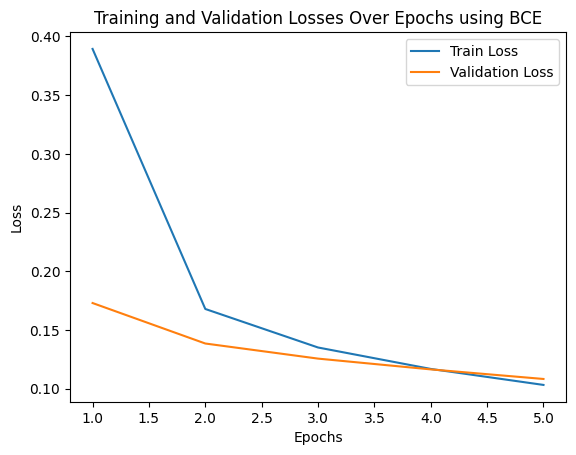

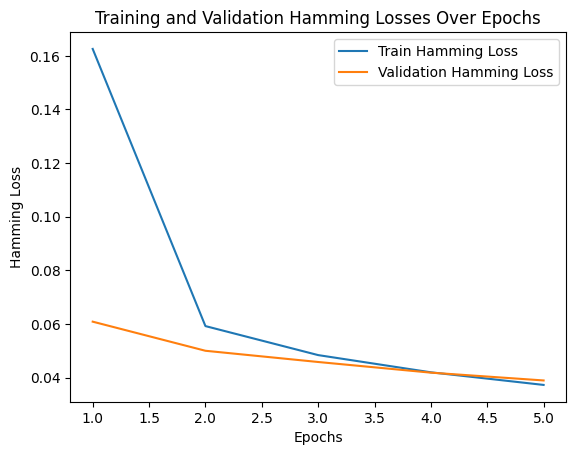

In [44]:
import matplotlib.pyplot as plt

def plot_history(train_losses, hamming_losses, val_losses=None, val_hamming_losses=None):
    """
    Plot training and validation loss and hamming loss over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        hamming_losses (list): List of training hamming losses for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_hamming_losses (list, optional): List of validation hamming losses for each epoch.

    Returns:
        None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")  # Plot training losses
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation Loss")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses Over Epochs using BCE")
    plt.show()

    # Plotting training and validation hamming losses
    plt.figure()
    plt.plot(epochs, hamming_losses, label="Train Hamming Loss")  # Plot training hamming losses
    if val_hamming_losses:
        plt.plot(epochs, val_hamming_losses, label="Validation Hamming Loss")  # Plot validation hamming losses
    plt.xlabel("Epochs")
    plt.ylabel("Hamming Loss")
    plt.legend()
    plt.title("Training and Validation Hamming Losses Over Epochs")
    plt.show()

plot_history(train_loss_history, train_hamming_loss_history, valid_loss_history, valid_hamming_loss_history)


In [47]:
import torch
from sklearn.metrics import hamming_loss

def get_ham_pred(valid_loader, model, device):
    """
    Get predictions and labels for the validation set and calculate overall Hamming loss.

    Args:
        model (torch.nn.Module): The trained neural network model.
        valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        device (torch.device): The computing device (CPU or GPU).

    Returns:
        overall_hamming_loss (float): Overall Hamming loss for the validation set.
        all_labels (torch.Tensor): Ground truth labels for the entire validation set.
        all_predictions (torch.Tensor): Predicted labels for the entire validation set.
    """
    model = model.to(device)
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to store predictions and labels for the entire validation set
    all_labels = []
    all_predictions = []

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move data to the device
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)

            # Perform a forward pass to get predictions
            outputs = model(inputs)

            # Apply sigmoid to convert model outputs to probabilities
            predictions = torch.sigmoid(outputs).round()

            # Append predictions and targets to the overall lists
            all_labels.append(targets.cpu())
            all_predictions.append(predictions.cpu())

    # Concatenate predictions and labels to obtain tensors for the entire validation set
    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    # Calculate overall Hamming loss using sklearn's hamming_loss function
    overall_hamming_loss = hamming_loss(all_labels.numpy(), all_predictions.numpy())

    return overall_hamming_loss, all_labels, all_predictions


In [48]:
# Get predictions and labels for the validation set
valid_hamming_loss, val_labels, val_predictions = get_ham_pred(valid_loader, model_slack, device)

# Move tensors to CPU before converting to NumPy arrays
val_labels_cpu = val_labels.cpu().numpy()
val_predictions_cpu = val_predictions.cpu().numpy()

# Print overall Hamming loss for the validation set
print(f"Hamming Loss for Validation Set: {valid_hamming_loss}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Hamming Loss for Validation Set: 0.03843964153927253


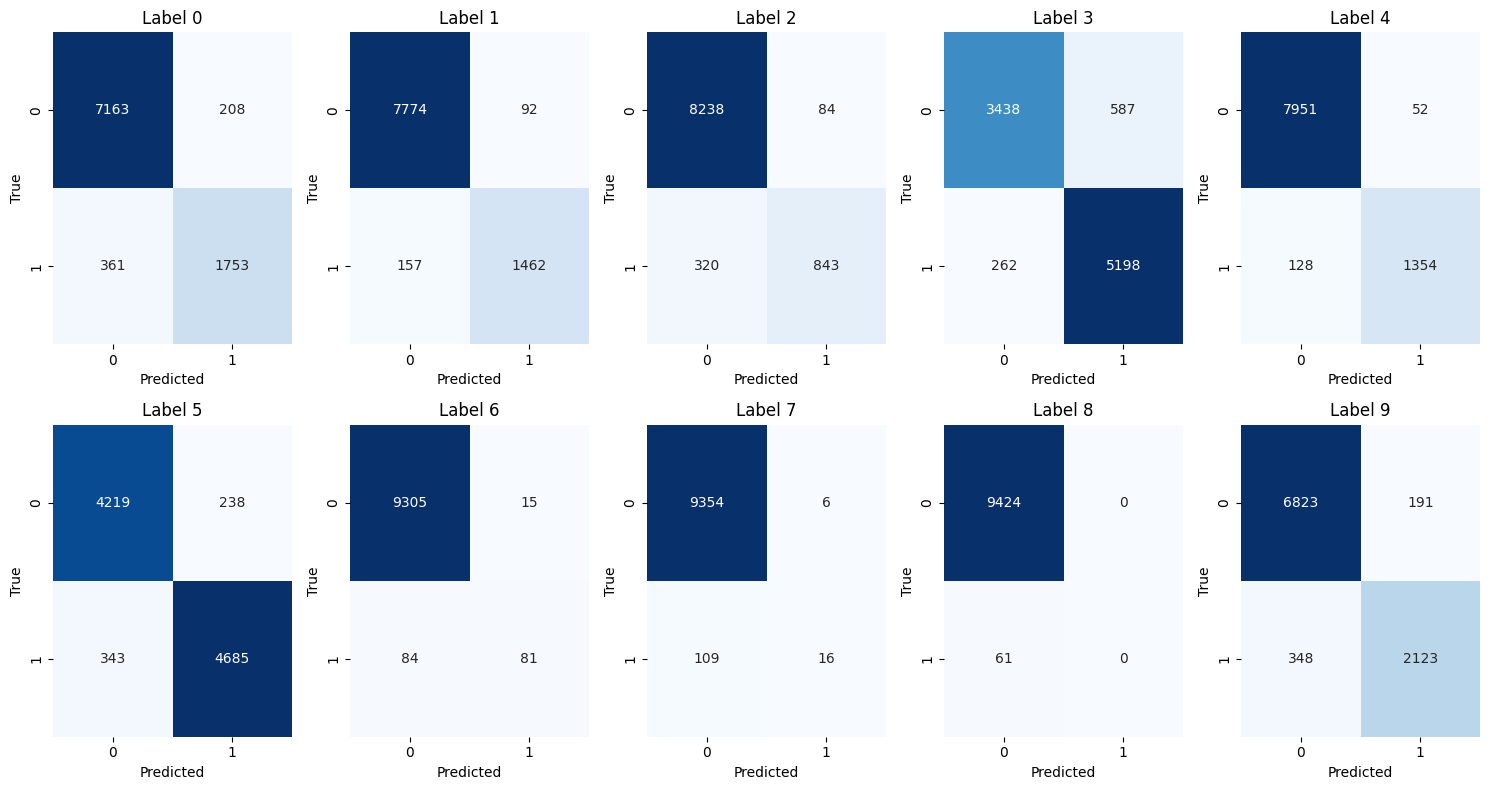

In [50]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Get multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(val_labels_cpu, val_predictions_cpu)

# Plot confusion matrix
plt.figure(figsize=(15, 8))
for i in range(NUM_OUTPUTS):
    plt.subplot(2, 5, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Label {i}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

# <font color = 'indianred'>**(2) Model Testing: evaluation on the test set** </font>

In [51]:
# Get predictions and labels for the validation set
test_hamming_loss, test_labels, test_predictions = get_ham_pred(test_loader, model_slack, device)

# Move tensors to CPU before converting to NumPy arrays
test_labels_cpu = test_labels.cpu().numpy()
test_predictions_cpu = test_predictions.cpu().numpy()

# Print overall Hamming loss for the validation set
print(f"Hamming Loss for Test Set: {test_hamming_loss}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Hamming Loss for Test Set: 0.0408707569049125


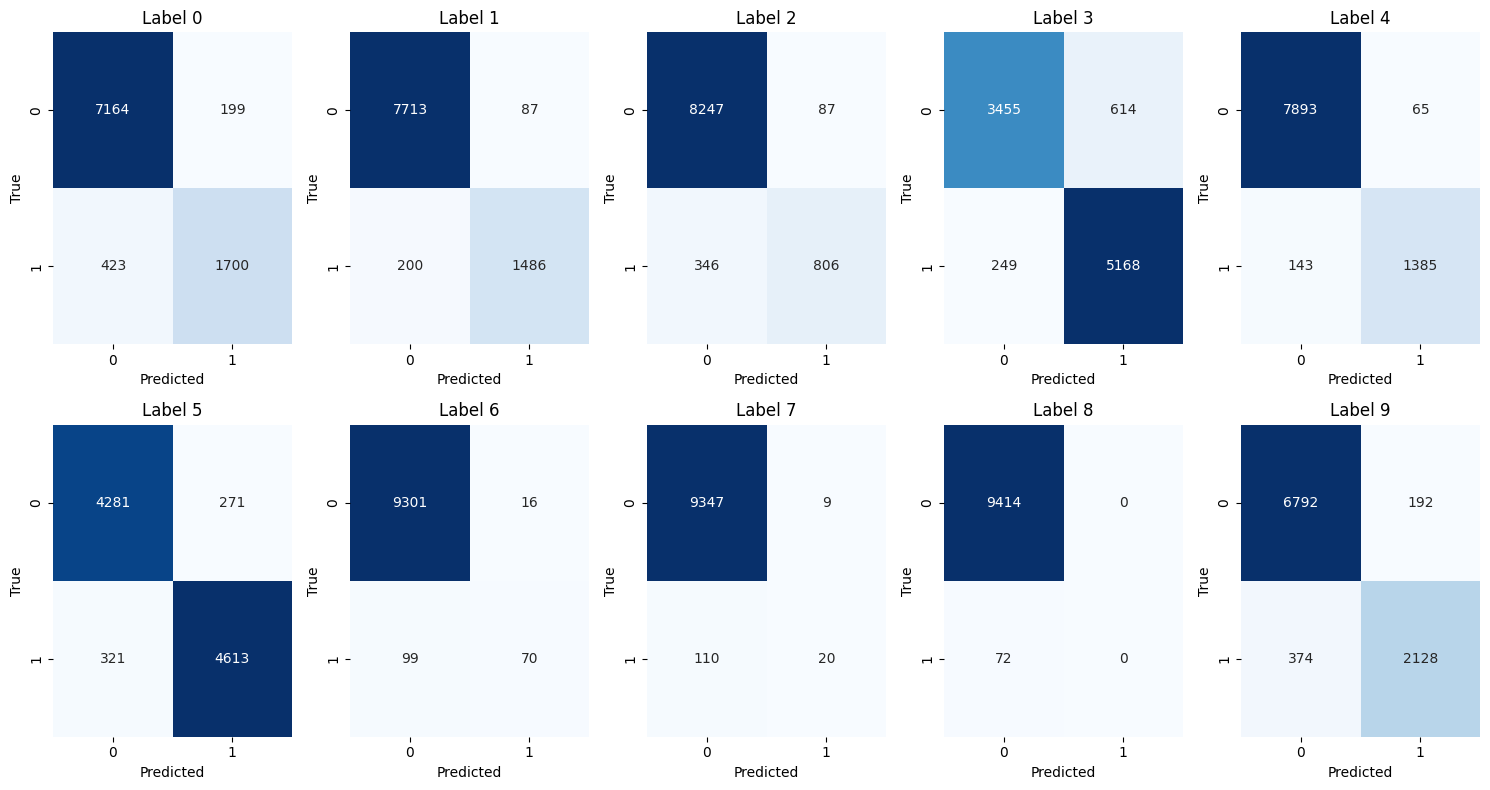

In [52]:
conf_matrix = multilabel_confusion_matrix(test_labels_cpu, test_predictions_cpu)

# Plot confusion matrix
plt.figure(figsize=(15, 8))
for i in range(NUM_OUTPUTS):
    plt.subplot(2, 5, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Label {i}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

# <font color = 'indianred'>**(3) Inference** </font>

In [53]:
sample_X = X_test_list[0:5]
sample_X

['open fancybox pageload situation open fancy box   page load   find html code success protect void page_load(object sender eventargs e                       sessioncontroller currentmember = null                               request isauthenticated                                       int memberid = sessioncontroller currentmember memberid                      bool checkaccepted = checkacceptedtermsandconditions(memberid                       checkaccepte                                               string script = < script>$(document).ready(function                    $ onlinecasinotandc"").fancybox                   transitionin      elastic                   transitionout    elastic                    speedin         600                       speedout        200                       overlayshow       false                       overlayopacity    0.5                         width             800                          showclosebutton   true                                     

In [54]:
device = 'cpu'

# Convert the list of texts into a list of lists;
list_of_list_of_indices = [tokenizer(text, slack_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

In [55]:
# move model to appropriate device
model_slack.to(device)

# put model in evaluation mode
model_slack.eval()

# get outputs (logits) from model
outputs = model_slack((indices, offsets))

In [56]:
# Apply sigmoid activation to get probabilities for each class
probabilities = torch.sigmoid(outputs)

# Set a threshold for prediction (you can adjust this threshold based on your problem)
threshold = 0.5

# Convert probabilities to binary predictions using the threshold
binary_predictions = (probabilities > threshold).int()

# Mapping for class labels
mapping = {0: 'c#', 1: 'java', 2: 'php', 3: 'javascript', 4: 'android', 5: 'jquery', 6: 'c++', 7: 'python', 8: 'iphone', 9: 'asp.net'}

# Get predicted labels for each sample
predicted_labels = [list(map(mapping.get, torch.nonzero(pred).squeeze().tolist())) for pred in binary_predictions]

print(predicted_labels)

[['javascript', 'asp.net'], ['java', 'android'], ['javascript', 'jquery'], ['javascript', 'jquery'], ['c#', 'javascript']]


In [57]:
sample_y = y_test_np[0:5]
sample_y

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1]])

In [58]:
# Mapping dictionary
mapping = {0: 'c#', 1: 'java', 2: 'php', 3: 'javascript', 4: 'android', 5: 'jquery', 6: 'c++', 7: 'python', 8: 'iphone', 9: 'asp.net'}

# Convert numerical labels to class names using the mapping
actual_labels = [[mapping[i] for i, label in enumerate(sample) if label == 1] for sample in sample_y]

# Display the mapped labels
print(actual_labels)

[['c#', 'jquery', 'asp.net'], ['java', 'android'], ['javascript', 'jquery'], ['javascript', 'jquery'], ['c#', 'javascript', 'asp.net']]


In [59]:
# Compare the predicted labels with the mapped labels
for i, (predicted, actual) in enumerate(zip(predicted_labels, actual_labels)):
    print(f"Example {i + 1}:")
    print(f"Predicted Labels: {predicted}")
    print(f"Actual Labels:    {actual}")
    print()

Example 1:
Predicted Labels: ['javascript', 'asp.net']
Actual Labels:    ['c#', 'jquery', 'asp.net']

Example 2:
Predicted Labels: ['java', 'android']
Actual Labels:    ['java', 'android']

Example 3:
Predicted Labels: ['javascript', 'jquery']
Actual Labels:    ['javascript', 'jquery']

Example 4:
Predicted Labels: ['javascript', 'jquery']
Actual Labels:    ['javascript', 'jquery']

Example 5:
Predicted Labels: ['c#', 'javascript']
Actual Labels:    ['c#', 'javascript', 'asp.net']

